In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 6 14:59:23 2020

@author: 박창희 (주)지오그린21
"""
import numpy as np # 넘파이
import pandas as pd
from math import sqrt # math
from tqdm import tqdm

from matplotlib import pyplot # 플롯을 그리기 위함
from pandas import read_csv # csv 파일 읽기
from pandas import DataFrame # dataframe 활용을 위함
from pandas import concat # dataframe 병합을 위함
from pandas import to_datetime, to_timedelta, date_range
from sklearn.preprocessing import MinMaxScaler # 최대최소 스케일러
from sklearn.metrics import mean_squared_error # mse
from sklearn.metrics import r2_score # r2

#tensorflow 2.0
from tensorflow.keras.models import Sequential, load_model # 시퀀스 모델을 사용하기 위함
from tensorflow.keras.layers import Dense, Dropout # Dense, Dropout을 사용하기 위함
from tensorflow.keras.layers import LSTM # lstm을 사용하기 위함
from tensorflow.keras.callbacks import EarlyStopping
import missingno as msno

import joblib
import pickle
import psycopg2 as pc
import os

In [ ]:
def elToCSV():
#     try:
    conn = pc.connect(database="SGMS_TEST",user="postgres",password="soda!1234",host="211.115.112.29",port="2005")
    curs = conn.cursor()

    DS_data = []
    rain_data = []
    DS1 = ["'DSB001'", "'DSB002'", "'DSB003'", "'DSB004'", "'DSA001'", "'DSA002'", "'DSA003'", "'DSA004'"]
    DS2 = ["'DSBH01_A'", "'DSBH02_A'", "'DSBH03_A'", "'DSBH04_A'", "'DSBH01_B'", "'DSBH02_B'", "'DSBH03_B'", "'DSBH04_B'"]
    for i in range(len(DS1)):
        sql = f"select   gvo.site_code, gvo.data_time, gvo.el, gwo.rain_day from gw_data_value_org gvo left join gw_weather_value_org gwo on gvo.data_time = gwo.data_time where   (gvo.site_code = {DS1[i]} or gvo.site_code = {DS2[i]}) and gvo.m_sn = 'S11' order by data_time desc"
        df = pd.read_sql(sql, conn)
        df[['data_time']] = to_datetime(df['data_time'].astype(str))
        df = df.rename(columns={'data_time':'_date'})
        df.set_index('_date', inplace=True, drop=True)
        df = df.loc[~df.index.duplicated(keep='first')]
        rain_df = DataFrame(df[['rain_day']].values, columns = ['rain_' + str(i+1)], index=df.index)
        df = DataFrame(df[['el']].values, columns = [DS2[i].replace("'", "")], index=df.index)
        DS_data.append(df)
        rain_data.append(rain_df)
    DS_data = concat(DS_data, axis=1)
    rain_df = concat(rain_data, axis=1)
    rain_data = DataFrame(rain_df.mean(axis=1), columns=['rain'])
    DS_data = concat((DS_data, rain_data), axis=1)
    DS_data.to_csv("HS_woNaN.csv", encoding='euc-kr', header = True, doublequote = True, sep=',', index=True)
    print("CSV File has been created")
    conn.close()
    return DS_data

In [ ]:
def CSVToDB():
    try:
        conn = pc.connect(database="SGMS_TEST",user="postgres",password="soda!1234",host="211.115.112.29",port="2005")
        curs = conn.cursor()

        curs.execute("DELETE FROM ta_ai_temp")
        conn.commit()

        copy_sql = """
                   COPY ta_ai_temp (site_code, data_time, m_sn, el) FROM stdin DELIMITER ',' CSV
                   """
        with open('pred_result.csv', 'r') as f:
            curs.copy_expert(copy_sql, f)
            print(f)  # 만약 파일의 이름만 출력하고 싶으면 f.name 사용

        sql = "INSERT INTO gw_data_value_ai (site_code, wal, pre_date, well_code)" + \
              " SELECT site_code, wal, pre_date, well_code FROM ta_ai_temp t" + \
              " ON CONFLICT ON CONSTRAINT ta_ai_data_key DO UPDATE SET(site_code, wal, pre_date, well_code) = (excluded.site_code, excluded.wal, excluded.pre_date, excluded.well_code)" + \
              " where ta_ai_data.site_code = excluded.site_code and ta_ai_data.well_code = excluded.well_code and excluded.pre_date = excluded.pre_date;"

        curs.execute(sql)
        conn.commit()

        curs.close()
        conn.close()
        print("DB Interted")
    except Exception as error:
        logger.warn("ERROR in CSVToDB function")
        logger.warn(error)

In [ ]:
def convert_data():
    df = pd.read_excel('HS_woNaN.csv')

    _date = df[df.columns[0]]
    _range = date_range(start = _date[0], end = _date[len(_date)-1], freq='10min')
    df.set_index(df.columns[0],inplace=True)
    _df = df.reindex(_range)
    _df = _df.drop([_df.columns[-1]], axis=1)

    # 음의 값 변환
    for i in __df.columns[1:9]:
        if min(__df[i].values) < 0:
            for j in __df[__df[i] < 0].index:
                __df.loc[j, i] = abs(__df.loc[j, i])

    trans_df_h = pd.DataFrame()
    trans_df = pd.DataFrame()

    # 1시간 단위로 변환
    __df['강수량'] = __df['강수량'].fillna(0)
    for j, i in tqdm(enumerate(__df.groupby(by = [__df['index'].dt.year, __df['index'].dt.month, __df['index'].dt.day, __df['index'].dt.hour]))):
        trans_df_h.loc[j, 'date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]) + ' ' + str(i[0][3]).zfill(2), format='%Y-%m-%d %H')
        for k in __df.columns[1:9]:
            try:
                trans_df_h.loc[j, k] = sum(i[1][k][i[1][k].notnull()])/len(i[1][k][i[1][k].notnull()])
            except:
                trans_df_h.loc[j, k] = np.nan
        trans_df_h.loc[j, 'rain'] = sum(i[1]['강수량'].values)

    # 1일 단위로 변환
    for j, i in tqdm(enumerate(trans_df_h.groupby(by = [trans_df_h.date.dt.year, trans_df_h.date.dt.month, trans_df_h.date.dt.day]))):
        trans_df.loc[j, '_date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]), format='%Y-%m-%d')
        for k in trans_df_h.columns[1:9]:
            try:
                trans_df.loc[j, k] = sum(i[1][k][i[1][k].notnull()])/len(i[1][k][i[1][k].notnull()])
            except:
                trans_df.loc[j, k] = np.nan
        trans_df.loc[j, 'rain'] = sum(i[1]['rain'].values)
        
    return trans_df

In [ ]:
# convert series to supervised learning lstm 사용 위해 시계열 시퀀스 데이터로 변환
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1) 시퀀스 데이터 추가하기
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n) 시퀀스 예측 데이터 추가하기
    for i in range(0, n_out):
        cols.append(df.shift(-i)) # 변환, 컬럼 추가
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)] # names에 예측 데이터 i = 0인 경우
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] # names에 예측 데이터

    # put it all together
    agg = concat(cols, axis=1) # 데이터 합치기
    agg.columns = names

    # drop rows with NaN values null값이 있는 행 지우기
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def model_predict(act_X):
    for i in range(7):
        zhat = model.predict(act_X) # 예측 데이터 활용한 예측
        act_X[:6,0,0] = act_X[1:7,0,0]
        act_X[-1,0,0] = zhat[-1,0]
    act_X = act_X.reshape((act_X.shape[0], act_X.shape[2]))
    return act_X, zhat

In [ ]:
def pred_to_csv(inv_zhat):
    actData = DataFrame(inv_zhat)
    actData.to_csv('predout.csv', header=False,index=False)

In [ ]:
def result_sum(xhat, yhat, train_X, train_y, test_X, test_y):
    # invert scaling for forecast
    inv_xhat = np.concatenate((xhat, train_X[:, 1:]), axis=1)
    inv_xhat = scaler.inverse_transform(inv_xhat)
    inv_xhat = inv_xhat[:,0]
    
    inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_x = np.concatenate((train_y, train_X[:, 1:]), axis=1)
    inv_x = scaler.inverse_transform(inv_x)
    inv_x = inv_x[:,0]
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # 결과 출력
    # calculate RMSE
    trainRMSE = sqrt(mean_squared_error(inv_x, inv_xhat))
    trainR2 = r2_score(inv_x, inv_xhat)
    print('Train RMSE : %.3f' % trainRMSE)
    print('Train R2 : %.3f' % trainR2)
    testRMSE = sqrt(mean_squared_error(inv_y, inv_yhat))
    testR2 = r2_score(inv_y, inv_yhat)
    print('Test RMSE : %.3f' % testRMSE)
    print('Test R2 : %.3f' % testR2)

    # plot baseline and prediction 실제, 예측, 검증 데이터 관련 그래프
    pyplot.plot(inv_y, label='actual')
    pyplot.plot(inv_yhat, label='test')
    pyplot.legend()
    pyplot.show()
    
    return testR2

In [ ]:
def model_fitting(train_X, train_y, test_X, test_y, model):
    # early_stopping
    # early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

    # fit network
    # 모델 적용(학습 횟수(epoch) : 200, 한 번에 학습하는 데이터 개수(batch_size) : 15, 검증 데이터 설정, verbose : 2, shuffle 안함)
    history = model.fit(train_X, train_y, epochs=200, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False) # , callbacks=[early_stop])
    
    # plot history 플롯 설정(훈련, 검증 셋)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # make a prediction 예측하기
    xhat = model.predict(train_X)
    yhat = model.predict(test_X) # 검증 데이터X 예측
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    

    return result_sum(xhat, yhat, train_X, train_y, test_X, test_y), model

In [ ]:
def model_compile(train_X):
# design network 모델 파라미터 설정
    model = Sequential() # 시퀀스 데이터 사용할 모델
    model.add(LSTM(60, activation = 'tanh', input_shape=(train_X.shape[1], train_X.shape[2]))) # lstm모델 설정(층 : 60, 활성함수 : 'tanh', 입력 데이터 형태(input_shape)
    model.add(Dropout(0.5)) # 과적합 방지를 위한 피쳐 드롭아웃 설정(모델의 50%)
    model.add(Dense(1, activation = 'linear')) # dense 설정(활성함수 = 'linear')
    model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae']) # 모델 컴파일(오차함수 : loss, 옵티마이저 = 'adam', 정확도)
    model.summary()
    print('loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: ')
    return model

In [ ]:
def split_data(values):
    trainSize = int(len(values)* 0.8)
    train = values[:trainSize, :]
    test = values[trainSize:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1] # 학습에 사용되는 데이터1, 2 (train[:, -1]가 도출될 수 있도록 하는 데이터와 train[:, -1] 데이터)
    test_X, test_y = test[:, :-1], test[:, -1] # 검증 데이터 (위와 같음)

    # reshape input to be 3D [samples, timesteps, features] 3차원 데이터로 변환
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print('train_X :', train_X.shape,
          '\ntrain_y :', train_y.shape,
          '\ntest_X :', test_X.shape,
          '\ntest_y :', test_y.shape)    
    
    model = model_compile(train_X)
    
    return model_fitting(train_X, train_y, test_X, test_y, model)

In [ ]:
def scaling(dataset):
    # ensure all data is float 데이터를 float32로 변환
    values = dataset.values
    values = values.astype('float32')
    
    # normalize features 피쳐 normalize
    global scaler
    scaler = MinMaxScaler(feature_range=(0, 1)) # 최대최소 스케일링(0, 1)
    scaled = scaler.fit_transform(values) # 지하수 데이터에 스케일러 적용
    return scaled

In [ ]:
def shift_data(values):
#     values = scaling(dataset)
    # frame as supervised learning 지도 학습 프레임
    reframed = series_to_supervised(values, 1, 1) # series_to_supervised 이용, 프레임 변환
    
    # drop columns we don't want to predict 예측하지 않는 컬럼 삭제
    reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
    display(reframed.head())

    # split into train and test sets
    values = reframed.values
    return split_data(values)

In [ ]:
# 날짜 기준
def term(trans_df):
    date_df = pd.DataFrame()
    for k in trans_df.columns[1:9]:
        _null = [j for j in trans_df[trans_df[k].isnull()].index]
        _data = [i for i in trans_df[trans_df[k].notnull()].index]  

        _start = [trans_df.loc[_data[0], '_date']]
        _finish = []

        for i in _null:
            if i+1 in _data:
                if trans_df.loc[i + 1, '_date'] == _start[0]:
                    pass
                else:
                    _start.append(trans_df.loc[i + 1, '_date'])

            if i-1 in _data:
                _finish.append(trans_df.loc[i - 1, '_date'])

        _finish.append(trans_df.loc[_data[-1], '_date'])

        s_df = pd.DataFrame()
        s_df[f'{k}_start'] = _start
        f_df = pd.DataFrame()
        f_df[f'{k}_finish'] = _finish

        a_df = pd.concat([s_df, f_df], axis=1)

        a_df[f'{k}_term'] = a_df[f'{k}_finish'] - a_df[f'{k}_start']


        for i in a_df.index:
            try:
                null_term = a_df.loc[i + 1, f'{k}_start'] - a_df.loc[i, f'{k}_finish'] - pd.Timedelta('1 days')
                if null_term == np.datetime64:
                    continue
                else:
                    a_df.loc[i, f'{k}_null'] = null_term

            except:
                pass

        date_df = pd.concat([date_df, a_df], axis=1)
            
    return date_df

In [ ]:
def data_read():
    df = pd.read_csv('HS_woNaN.csv', parse_dates=['_date'])
    df.reset_index(drop=True, inplace=True)
    _range = date_range(start = df['_date'][0], end = df['_date'][len(df)-1], freq='10min')
    df.set_index('_date',inplace=True)
    _df = df.reindex(_range)

        # 음의 값 변환
    for i in _df.columns[1:9]:
        if min(_df[i].values) < 0:
            for j in _df[_df[i] < 0].index:
                _df.loc[j, i] = abs(_df.loc[j, i])
    
    trans_df = pd.DataFrame()    
    trans_df_h = pd.DataFrame()

    # 1시간 단위로 변환
    _df['rain'] = _df['rain'].fillna(0)
    _df.reset_index(drop=False, inplace=True)
    for j, i in tqdm(enumerate(_df.groupby(by = [_df['index'].dt.year, _df['index'].dt.month, _df['index'].dt.day, _df['index'].dt.hour]))):
        trans_df_h.loc[j, '_date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]) + ' ' + str(i[0][3]).zfill(2), format='%Y-%m-%d %H')
        for k in _df.columns[1:9]:
            try:
                trans_df_h.loc[j, k] = i[1][k].mean(axis=0)
            except:
                trans_df_h.loc[j, k] = np.nan
        trans_df_h.loc[j, 'rain'] = sum(i[1]['rain'].values)

    # 1일 단위로 변환
    for j, i in tqdm(enumerate(trans_df_h.groupby(by = [trans_df_h._date.dt.year, trans_df_h._date.dt.month, trans_df_h._date.dt.day]))):
        trans_df.loc[j, '_date'] = to_datetime(str(i[0][0]) + '-' + str(i[0][1]) + '-' + str(i[0][2]), format='%Y-%m-%d')
        for k in trans_df_h.columns[1:9]:
            try:
                trans_df.loc[j, k] = i[1][k].mean(axis=0)
            except:
                trans_df.loc[j, k] = np.nan
        trans_df.loc[j, 'rain'] = sum(i[1]['rain'].values)
    trans_df.set_index('_date', drop=True, inplace=True)
        
    return trans_df

In [ ]:
def rain_data(trans_df):
    rain_data = DataFrame(index=date_range(trans_df.index[-1] + to_timedelta('1d'), periods=7), columns=trans_df.columns)    
    for i in rain_data.columns:
        trans_df[[i]] = trans_df[[i]].interpolate(method='linear')
        rain_data[[i]] = trans_df[i][-1]
    rain7 = pd.concat([trans_df, rain_data])
    rain7 = rain7.astype('float32')
    rain7[['rain']] = rain7[['rain']].interpolate(method='linear')
    rain7 = rain7.iloc[-14:, :]
    return rain7

In [ ]:
def imsi(trans_df, spot, n):
    trans_df = trans_df[['_date', spot, 'rain']][n]
    trans_df = trans_df.interpolate(method='linear')
    trans_df = trans_df.set_index('_date')
    return trans_df

In [ ]:
# start(num) : 0-모델 재생성 1-모델 적용

def start(number):
    elToCSV()
    # csv 파일 읽기
    trans_df = data_read()
    display(trans_df)

    # 모델 재생성
    if number == 0:
        try:
            spot_list = trans_df.columns[:8]
            trans_df = trans_df.reset_index()
            date_df = term(trans_df)
            display(date_df)
            for j in spot_list:
                spot = str(j)
                print('='*7, spot, '='*7)
                try:
                    upper = (trans_df._date >= pd.Timestamp(date_df.loc[0, f'{spot}_start'])) & (trans_df._date <= pd.Timestamp((date_df[f'{spot}_finish'][date_df[f'{spot}_null'] == date_df[f'{spot}_null'].max()]).values[0]))
                    lower = (trans_df._date >= pd.Timestamp(date_df.loc[(date_df[f'{spot}_finish'][date_df[f'{spot}_null'] == date_df[f'{spot}_null'].max()].index + 1), f'{spot}_start'].values[0]))


                    if len(trans_df[['_date']][upper]) >= len(trans_df[['_date']][lower]):
                        dataset = imsi(trans_df, spot, upper)
                    elif len(trans_df[['_date']][upper]) < len(trans_df[['_date']][lower]):    
                        dataset = imsi(trans_df, spot, lower)
                except:
                    dataset = imsi(trans_df, spot, (trans_df._date >= pd.Timestamp(date_df.loc[0, f'{spot}_start'])))
                    
                # ensure all data is float 데이터를 float32로 변환
                values = dataset.values
                values = values.astype('float32')

                # normalize features 피쳐 normalize
                global scaler
                scaler = MinMaxScaler(feature_range=(0, 1)) # 최대최소 스케일링(0, 1)
                scaled = scaler.fit_transform(values) # 지하수 데이터에 스케일러 적용
                
                file_name = 'models/' + 'model' + '_' + spot
                coin = 1
                while True:
                    print(f'{coin}번 째 시도')
                    result, model = shift_data(scaled)
                    if result < 0.9:
                        coin += 1
                        continue
                    else:
                        joblib.dump(scaler, f'{file_name}_scaler.save')
                        print(f"{spot} 스케일러가 저장되었습니다.\n") 
                        model.save(f'{file_name}.h5')
                        print(f"{spot} 모델이 저장되었습니다.\n")
                        break

        except:
            print("모델 생성에 문제가 있습니다.\n")
            
    # 모델 적용            
    elif number == 1:
        try:
            rain7 = rain_data(trans_df)
            result_df = []
            # 모델 불러와서 결과
            for i in rain7.columns[:-1]:
                print(i)
                load_dir = 'models/model_' + str(i)
                scaler = joblib.load(load_dir + '_scaler.save')
                model = load_model(load_dir + '.h5')
                model.summary()

                pred_X = scaler.transform(rain7[[i, 'rain']].values) # 지하수 데이터에 스케일러 적용
                for j in range(7):
                    act_X = pred_X[j:j+7]
                    act_X = act_X.reshape(act_X.shape[0], 1, act_X.shape[1])
                    zhat = model.predict(act_X)
                    pred_X[j+7, 0] = zhat[-1]
                result = DataFrame((scaler.inverse_transform(pred_X))[:, 0], columns = [i], index = rain7.index)
                
                pyplot.plot(result.values)
                pyplot.axvline(x=6, color='r')
                pyplot.show()
                
                result_df.append(result)
            result_df = pd.concat(result_df, axis=1).iloc[-7:, :]
            display(result_df)

            result_df = trans_DB(result_df)

            result_df.to_csv('pred_result.csv', encoding='euc-kr', header=True, index=False)
            print("CSV is saved")
            CSVToDB()
            print("Process is finished")
        
        except:
            print("모델 적용에 문제가 있습니다.")
            
    else:
        print("start(0) : 모델 재생성,  start(1) : 모델 적용")

CSV File has been created


23922it [02:07, 188.02it/s]
998it [00:03, 328.79it/s]


,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.374598,NaN,26.035976,NaN,29.762949,NaN,29.857251,0.0
2018-11-14,NaN,29.450510,NaN,26.032637,NaN,29.753466,NaN,29.855676,0.0
2018-11-15,NaN,29.542585,NaN,25.936289,NaN,29.764339,NaN,29.873859,0.0
2018-11-16,NaN,29.654344,NaN,25.297936,NaN,29.853032,NaN,29.973508,0.0
2018-11-17,NaN,29.599985,NaN,25.352791,NaN,29.841348,NaN,29.936141,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2021-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2021-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


,DSBH01_A_start,DSBH01_A_finish,DSBH01_A_term,DSBH01_A_null,DSBH02_A_start,DSBH02_A_finish,DSBH02_A_term,DSBH02_A_null,DSBH03_A_start,DSBH03_A_finish,...,DSBH02_B_term,DSBH02_B_null,DSBH03_B_start,DSBH03_B_finish,DSBH03_B_term,DSBH03_B_null,DSBH04_B_start,DSBH04_B_finish,DSBH04_B_term,DSBH04_B_null
0,2019-05-09,2019-08-20,103 days,9 days,2018-11-13,2018-12-11,28 days,1 days,2019-05-09,2020-10-16,...,28 days,1 days,2019-05-30,2020-01-15,230 days,51 days,2018-11-13,2018-12-11,28 days,1 days
1,2019-08-30,2019-09-19,20 days,4 days,2018-12-13,2019-09-17,278 days,1 days,2021-02-24,2021-03-05,...,727 days,76 days,2020-03-07,2020-12-09,277 days,76 days,2018-12-13,2019-05-02,140 days,1 days
2,2019-09-24,2019-11-07,44 days,1 days,2019-09-19,2020-12-09,447 days,76 days,2021-03-08,2021-03-25,...,9 days,2 days,2021-02-24,2021-03-05,9 days,2 days,2019-05-04,2019-10-24,173 days,1 days
3,2019-11-09,2020-12-09,396 days,76 days,2021-02-24,2021-03-05,9 days,2 days,2021-03-29,2021-04-06,...,17 days,3 days,2021-03-08,2021-03-25,17 days,3 days,2019-10-26,2019-10-26,0 days,1 days
4,2021-02-24,2021-03-05,9 days,2 days,2021-03-08,2021-03-25,17 days,3 days,2021-04-13,2021-05-20,...,52 days,NaT,2021-03-29,2021-05-20,52 days,NaT,2019-10-28,2019-10-31,3 days,5 days
5,2021-03-08,2021-03-25,17 days,3 days,2021-03-29,2021-05-20,52 days,NaT,NaT,2021-05-20,...,NaT,NaT,NaT,2021-05-20,NaT,NaT,2019-11-06,2019-12-04,28 days,1 days
6,2021-03-29,2021-03-30,1 days,1 days,NaT,2021-05-20,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-12-06,2019-12-10,4 days,2 days
7,2021-04-01,2021-05-20,49 days,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-12-13,2020-04-11,120 days,1 days
8,NaT,2021-05-20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-04-13,2020-06-26,74 days,1 days
9,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-06-28,2020-07-11,13 days,4 days


======= DSBH01_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.444362,0.0,0.505793
2,0.505793,0.0,0.512082
3,0.512082,0.0,0.508533
4,0.508533,0.0,0.506716
5,0.506716,0.0,0.505333


train_X : (464, 1, 2) 
train_y : (464,) 
test_X : (116, 1, 2) 
test_y : (116,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60)                15120     
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
31/31 - 2s - loss: 0.2696 - acc: 0.0022 - mae: 0.4935 - val_loss: 0.4784 - val_acc: 0.0000e+00 - val_mae: 0.6898
Epoch 2/200
31/31 - 0s - loss: 0.1275 - acc: 0.0022 - mae: 0.3351 - val_loss: 0.2222 - val_acc: 0.0000e+00 - val_mae

Epoch 61/200
31/31 - 0s - loss: 0.0053 - acc: 0.0022 - mae: 0.0564 - val_loss: 4.0046e-04 - val_acc: 0.0086 - val_mae: 0.0155
Epoch 62/200
31/31 - 0s - loss: 0.0059 - acc: 0.0022 - mae: 0.0596 - val_loss: 3.6781e-04 - val_acc: 0.0086 - val_mae: 0.0144
Epoch 63/200
31/31 - 0s - loss: 0.0054 - acc: 0.0022 - mae: 0.0573 - val_loss: 3.0810e-04 - val_acc: 0.0086 - val_mae: 0.0107
Epoch 64/200
31/31 - 0s - loss: 0.0061 - acc: 0.0022 - mae: 0.0604 - val_loss: 3.1876e-04 - val_acc: 0.0086 - val_mae: 0.0120
Epoch 65/200
31/31 - 0s - loss: 0.0050 - acc: 0.0022 - mae: 0.0533 - val_loss: 2.3534e-04 - val_acc: 0.0086 - val_mae: 0.0081
Epoch 66/200
31/31 - 0s - loss: 0.0049 - acc: 0.0022 - mae: 0.0546 - val_loss: 2.5376e-04 - val_acc: 0.0086 - val_mae: 0.0087
Epoch 67/200
31/31 - 0s - loss: 0.0052 - acc: 0.0022 - mae: 0.0555 - val_loss: 5.1518e-04 - val_acc: 0.0086 - val_mae: 0.0191
Epoch 68/200
31/31 - 0s - loss: 0.0054 - acc: 0.0022 - mae: 0.0570 - val_loss: 2.3788e-04 - val_acc: 0.0086 - val_mae:

Epoch 126/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0406 - val_loss: 3.7264e-04 - val_acc: 0.0086 - val_mae: 0.0147
Epoch 127/200
31/31 - 0s - loss: 0.0027 - acc: 0.0022 - mae: 0.0361 - val_loss: 2.9714e-04 - val_acc: 0.0086 - val_mae: 0.0113
Epoch 128/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0407 - val_loss: 2.3854e-04 - val_acc: 0.0086 - val_mae: 0.0079
Epoch 129/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0389 - val_loss: 2.5629e-04 - val_acc: 0.0086 - val_mae: 0.0092
Epoch 130/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0389 - val_loss: 2.7084e-04 - val_acc: 0.0086 - val_mae: 0.0098
Epoch 131/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0391 - val_loss: 2.6075e-04 - val_acc: 0.0086 - val_mae: 0.0088
Epoch 132/200
31/31 - 0s - loss: 0.0027 - acc: 0.0022 - mae: 0.0366 - val_loss: 2.7966e-04 - val_acc: 0.0086 - val_mae: 0.0103
Epoch 133/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0385 - val_loss: 3.3082e-04 - val_acc: 0.0086 - 

Epoch 191/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0283 - val_loss: 2.6594e-04 - val_acc: 0.0086 - val_mae: 0.0106
Epoch 192/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0285 - val_loss: 3.1670e-04 - val_acc: 0.0086 - val_mae: 0.0132
Epoch 193/200
31/31 - 0s - loss: 0.0022 - acc: 0.0022 - mae: 0.0294 - val_loss: 2.4089e-04 - val_acc: 0.0086 - val_mae: 0.0083
Epoch 194/200
31/31 - 0s - loss: 0.0019 - acc: 0.0022 - mae: 0.0278 - val_loss: 2.9387e-04 - val_acc: 0.0086 - val_mae: 0.0119
Epoch 195/200
31/31 - 0s - loss: 0.0025 - acc: 0.0022 - mae: 0.0289 - val_loss: 2.2038e-04 - val_acc: 0.0086 - val_mae: 0.0070
Epoch 196/200
31/31 - 0s - loss: 0.0023 - acc: 0.0022 - mae: 0.0278 - val_loss: 3.0232e-04 - val_acc: 0.0086 - val_mae: 0.0125
Epoch 197/200
31/31 - 0s - loss: 0.0024 - acc: 0.0022 - mae: 0.0283 - val_loss: 2.5790e-04 - val_acc: 0.0086 - val_mae: 0.0099
Epoch 198/200
31/31 - 0s - loss: 0.0020 - acc: 0.0022 - mae: 0.0280 - val_loss: 2.5865e-04 - val_acc: 0.0086 - 

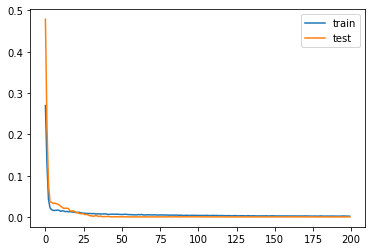

Train RMSE : 0.444
Train R2 : 0.944
Test RMSE : 0.206
Test R2 : 0.895


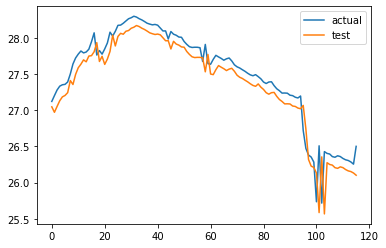

2번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.444362,0.0,0.505793
2,0.505793,0.0,0.512082
3,0.512082,0.0,0.508533
4,0.508533,0.0,0.506716
5,0.506716,0.0,0.505333


train_X : (464, 1, 2) 
train_y : (464,) 
test_X : (116, 1, 2) 
test_y : (116,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
31/31 - 2s - loss: 0.3005 - acc: 0.0022 - mae: 0.5216 - val_loss: 0.5510 - val_acc: 0.0000e+00 - val_mae: 0.7405
Epoch 2/200
31/31 - 0s - loss: 0.1590 - acc: 0.0022 - mae: 0.3765 - val_loss: 0.2910 - val_acc: 0.0000e+00 - val_m

Epoch 61/200
31/31 - 0s - loss: 0.0057 - acc: 0.0022 - mae: 0.0594 - val_loss: 2.8321e-04 - val_acc: 0.0086 - val_mae: 0.0102
Epoch 62/200
31/31 - 0s - loss: 0.0058 - acc: 0.0022 - mae: 0.0604 - val_loss: 2.3628e-04 - val_acc: 0.0086 - val_mae: 0.0083
Epoch 63/200
31/31 - 0s - loss: 0.0056 - acc: 0.0022 - mae: 0.0589 - val_loss: 3.9391e-04 - val_acc: 0.0086 - val_mae: 0.0155
Epoch 64/200
31/31 - 0s - loss: 0.0055 - acc: 0.0022 - mae: 0.0580 - val_loss: 2.3698e-04 - val_acc: 0.0086 - val_mae: 0.0082
Epoch 65/200
31/31 - 0s - loss: 0.0061 - acc: 0.0022 - mae: 0.0609 - val_loss: 3.8925e-04 - val_acc: 0.0086 - val_mae: 0.0153
Epoch 66/200
31/31 - 0s - loss: 0.0056 - acc: 0.0022 - mae: 0.0580 - val_loss: 2.9751e-04 - val_acc: 0.0086 - val_mae: 0.0116
Epoch 67/200
31/31 - 0s - loss: 0.0049 - acc: 0.0022 - mae: 0.0544 - val_loss: 4.4121e-04 - val_acc: 0.0086 - val_mae: 0.0171
Epoch 68/200
31/31 - 0s - loss: 0.0049 - acc: 0.0022 - mae: 0.0548 - val_loss: 7.3552e-04 - val_acc: 0.0086 - val_mae:

Epoch 126/200
31/31 - 0s - loss: 0.0032 - acc: 0.0022 - mae: 0.0414 - val_loss: 2.7298e-04 - val_acc: 0.0086 - val_mae: 0.0099
Epoch 127/200
31/31 - 0s - loss: 0.0029 - acc: 0.0022 - mae: 0.0397 - val_loss: 2.7520e-04 - val_acc: 0.0086 - val_mae: 0.0099
Epoch 128/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0400 - val_loss: 3.5721e-04 - val_acc: 0.0086 - val_mae: 0.0134
Epoch 129/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0400 - val_loss: 2.7959e-04 - val_acc: 0.0086 - val_mae: 0.0100
Epoch 130/200
31/31 - 0s - loss: 0.0029 - acc: 0.0022 - mae: 0.0389 - val_loss: 2.5319e-04 - val_acc: 0.0086 - val_mae: 0.0088
Epoch 131/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0385 - val_loss: 2.4083e-04 - val_acc: 0.0086 - val_mae: 0.0083
Epoch 132/200
31/31 - 0s - loss: 0.0032 - acc: 0.0022 - mae: 0.0407 - val_loss: 2.4049e-04 - val_acc: 0.0086 - val_mae: 0.0083
Epoch 133/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0406 - val_loss: 2.3959e-04 - val_acc: 0.0086 - 

Epoch 191/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0294 - val_loss: 2.8806e-04 - val_acc: 0.0086 - val_mae: 0.0117
Epoch 192/200
31/31 - 0s - loss: 0.0022 - acc: 0.0022 - mae: 0.0297 - val_loss: 2.2813e-04 - val_acc: 0.0086 - val_mae: 0.0073
Epoch 193/200
31/31 - 0s - loss: 0.0022 - acc: 0.0022 - mae: 0.0295 - val_loss: 2.8638e-04 - val_acc: 0.0086 - val_mae: 0.0117
Epoch 194/200
31/31 - 0s - loss: 0.0023 - acc: 0.0022 - mae: 0.0284 - val_loss: 2.7370e-04 - val_acc: 0.0086 - val_mae: 0.0108
Epoch 195/200
31/31 - 0s - loss: 0.0023 - acc: 0.0022 - mae: 0.0293 - val_loss: 3.3962e-04 - val_acc: 0.0086 - val_mae: 0.0141
Epoch 196/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0278 - val_loss: 3.0014e-04 - val_acc: 0.0086 - val_mae: 0.0125
Epoch 197/200
31/31 - 0s - loss: 0.0025 - acc: 0.0022 - mae: 0.0308 - val_loss: 2.9796e-04 - val_acc: 0.0086 - val_mae: 0.0123
Epoch 198/200
31/31 - 0s - loss: 0.0022 - acc: 0.0022 - mae: 0.0282 - val_loss: 2.3251e-04 - val_acc: 0.0086 - 

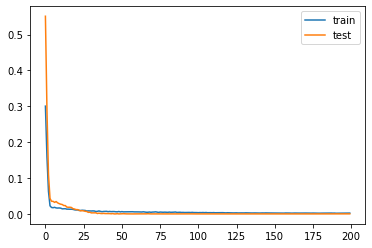

Train RMSE : 0.456
Train R2 : 0.941
Test RMSE : 0.227
Test R2 : 0.872


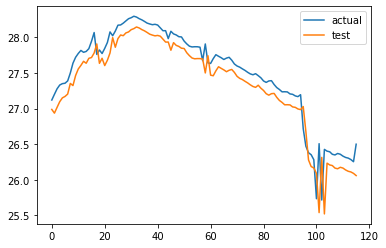

3번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.444362,0.0,0.505793
2,0.505793,0.0,0.512082
3,0.512082,0.0,0.508533
4,0.508533,0.0,0.506716
5,0.506716,0.0,0.505333


train_X : (464, 1, 2) 
train_y : (464,) 
test_X : (116, 1, 2) 
test_y : (116,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
31/31 - 2s - loss: 0.2647 - acc: 0.0022 - mae: 0.4888 - val_loss: 0.4752 - val_acc: 0.0000e+00 - val_mae: 0.6874
Epoch 2/200
31/31 - 0s - loss: 0.1291 - acc: 0.0022 - mae: 0.3379 - val_loss: 0.2304 - val_acc: 0.0000e+00 - val_m

Epoch 61/200
31/31 - 0s - loss: 0.0060 - acc: 0.0022 - mae: 0.0592 - val_loss: 3.2266e-04 - val_acc: 0.0086 - val_mae: 0.0130
Epoch 62/200
31/31 - 0s - loss: 0.0057 - acc: 0.0022 - mae: 0.0587 - val_loss: 2.4481e-04 - val_acc: 0.0086 - val_mae: 0.0083
Epoch 63/200
31/31 - 0s - loss: 0.0050 - acc: 0.0022 - mae: 0.0559 - val_loss: 3.6573e-04 - val_acc: 0.0086 - val_mae: 0.0146
Epoch 64/200
31/31 - 0s - loss: 0.0055 - acc: 0.0022 - mae: 0.0575 - val_loss: 2.7952e-04 - val_acc: 0.0086 - val_mae: 0.0106
Epoch 65/200
31/31 - 0s - loss: 0.0052 - acc: 0.0022 - mae: 0.0558 - val_loss: 2.6653e-04 - val_acc: 0.0086 - val_mae: 0.0097
Epoch 66/200
31/31 - 0s - loss: 0.0056 - acc: 0.0022 - mae: 0.0575 - val_loss: 2.3234e-04 - val_acc: 0.0086 - val_mae: 0.0078
Epoch 67/200
31/31 - 0s - loss: 0.0052 - acc: 0.0022 - mae: 0.0565 - val_loss: 3.7864e-04 - val_acc: 0.0086 - val_mae: 0.0153
Epoch 68/200
31/31 - 0s - loss: 0.0048 - acc: 0.0022 - mae: 0.0538 - val_loss: 3.2127e-04 - val_acc: 0.0086 - val_mae:

Epoch 126/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0376 - val_loss: 2.4953e-04 - val_acc: 0.0086 - val_mae: 0.0083
Epoch 127/200
31/31 - 0s - loss: 0.0033 - acc: 0.0022 - mae: 0.0410 - val_loss: 2.3976e-04 - val_acc: 0.0086 - val_mae: 0.0080
Epoch 128/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0390 - val_loss: 2.9713e-04 - val_acc: 0.0086 - val_mae: 0.0117
Epoch 129/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0393 - val_loss: 2.7968e-04 - val_acc: 0.0086 - val_mae: 0.0106
Epoch 130/200
31/31 - 0s - loss: 0.0031 - acc: 0.0022 - mae: 0.0385 - val_loss: 3.1804e-04 - val_acc: 0.0086 - val_mae: 0.0127
Epoch 131/200
31/31 - 0s - loss: 0.0032 - acc: 0.0022 - mae: 0.0412 - val_loss: 2.7321e-04 - val_acc: 0.0086 - val_mae: 0.0102
Epoch 132/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0385 - val_loss: 2.5599e-04 - val_acc: 0.0086 - val_mae: 0.0087
Epoch 133/200
31/31 - 0s - loss: 0.0030 - acc: 0.0022 - mae: 0.0387 - val_loss: 2.3864e-04 - val_acc: 0.0086 - 

Epoch 191/200
31/31 - 0s - loss: 0.0023 - acc: 0.0022 - mae: 0.0296 - val_loss: 3.1944e-04 - val_acc: 0.0086 - val_mae: 0.0132
Epoch 192/200
31/31 - 0s - loss: 0.0024 - acc: 0.0022 - mae: 0.0303 - val_loss: 2.2455e-04 - val_acc: 0.0086 - val_mae: 0.0074
Epoch 193/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0276 - val_loss: 2.3362e-04 - val_acc: 0.0086 - val_mae: 0.0082
Epoch 194/200
31/31 - 0s - loss: 0.0022 - acc: 0.0022 - mae: 0.0287 - val_loss: 3.3936e-04 - val_acc: 0.0086 - val_mae: 0.0143
Epoch 195/200
31/31 - 0s - loss: 0.0024 - acc: 0.0022 - mae: 0.0279 - val_loss: 2.3690e-04 - val_acc: 0.0086 - val_mae: 0.0086
Epoch 196/200
31/31 - 0s - loss: 0.0023 - acc: 0.0022 - mae: 0.0288 - val_loss: 2.9140e-04 - val_acc: 0.0086 - val_mae: 0.0123
Epoch 197/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0281 - val_loss: 5.7805e-04 - val_acc: 0.0086 - val_mae: 0.0214
Epoch 198/200
31/31 - 0s - loss: 0.0021 - acc: 0.0022 - mae: 0.0278 - val_loss: 4.7549e-04 - val_acc: 0.0086 - 

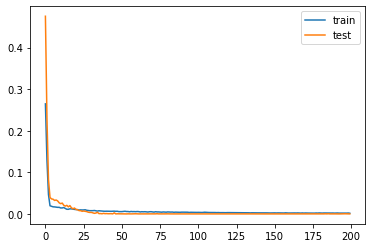

Train RMSE : 0.441
Train R2 : 0.945
Test RMSE : 0.181
Test R2 : 0.918


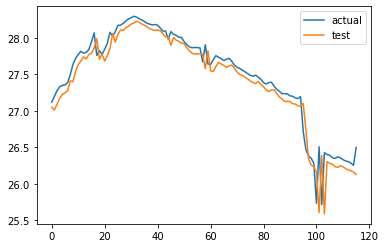

DSBH01_A 스케일러가 저장되었습니다.

DSBH01_A 모델이 저장되었습니다.

======= DSBH02_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.466703,0.0,0.482267
2,0.482267,0.0,0.501144
3,0.501144,0.0,0.524057
4,0.524057,0.0,0.512912
5,0.512912,0.0,0.523040


train_X : (605, 1, 2) 
train_y : (605,) 
test_X : (152, 1, 2) 
test_y : (152,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
41/41 - 2s - loss: 0.0873 - acc: 0.0017 - mae: 0.2324 - val_loss: 0.3977 - val_acc: 0.0000e+00 - val_mae: 0.5844
Epoch 2/200
41/41 - 0s - loss: 0.0448 - acc: 0.0017 - mae: 0.1497 - val_loss: 0.2538 - val_acc: 0.0000e+00 - val_m

Epoch 60/200
41/41 - 0s - loss: 0.0012 - acc: 0.0017 - mae: 0.0230 - val_loss: 6.7679e-04 - val_acc: 0.0066 - val_mae: 0.0214
Epoch 61/200
41/41 - 0s - loss: 0.0013 - acc: 0.0017 - mae: 0.0238 - val_loss: 6.6124e-04 - val_acc: 0.0066 - val_mae: 0.0211
Epoch 62/200
41/41 - 0s - loss: 9.6423e-04 - acc: 0.0017 - mae: 0.0219 - val_loss: 4.5209e-04 - val_acc: 0.0066 - val_mae: 0.0171
Epoch 63/200
41/41 - 0s - loss: 0.0010 - acc: 0.0017 - mae: 0.0225 - val_loss: 8.0238e-04 - val_acc: 0.0066 - val_mae: 0.0235
Epoch 64/200
41/41 - 0s - loss: 0.0011 - acc: 0.0017 - mae: 0.0217 - val_loss: 5.6992e-04 - val_acc: 0.0066 - val_mae: 0.0195
Epoch 65/200
41/41 - 0s - loss: 0.0011 - acc: 0.0017 - mae: 0.0232 - val_loss: 4.0990e-04 - val_acc: 0.0066 - val_mae: 0.0162
Epoch 66/200
41/41 - 0s - loss: 0.0011 - acc: 0.0017 - mae: 0.0225 - val_loss: 4.1489e-04 - val_acc: 0.0066 - val_mae: 0.0161
Epoch 67/200
41/41 - 0s - loss: 9.0271e-04 - acc: 0.0017 - mae: 0.0211 - val_loss: 5.6615e-04 - val_acc: 0.0066 - 

Epoch 124/200
41/41 - 0s - loss: 6.8518e-04 - acc: 0.0017 - mae: 0.0189 - val_loss: 3.4136e-04 - val_acc: 0.0066 - val_mae: 0.0127
Epoch 125/200
41/41 - 0s - loss: 7.3981e-04 - acc: 0.0017 - mae: 0.0186 - val_loss: 6.7803e-04 - val_acc: 0.0066 - val_mae: 0.0221
Epoch 126/200
41/41 - 0s - loss: 7.6952e-04 - acc: 0.0017 - mae: 0.0188 - val_loss: 3.6914e-04 - val_acc: 0.0066 - val_mae: 0.0137
Epoch 127/200
41/41 - 0s - loss: 6.7237e-04 - acc: 0.0017 - mae: 0.0177 - val_loss: 6.5085e-04 - val_acc: 0.0066 - val_mae: 0.0216
Epoch 128/200
41/41 - 0s - loss: 5.9561e-04 - acc: 0.0017 - mae: 0.0172 - val_loss: 3.4554e-04 - val_acc: 0.0066 - val_mae: 0.0146
Epoch 129/200
41/41 - 0s - loss: 5.6648e-04 - acc: 0.0017 - mae: 0.0171 - val_loss: 4.5046e-04 - val_acc: 0.0066 - val_mae: 0.0167
Epoch 130/200
41/41 - 0s - loss: 7.0842e-04 - acc: 0.0017 - mae: 0.0178 - val_loss: 4.2824e-04 - val_acc: 0.0066 - val_mae: 0.0168
Epoch 131/200
41/41 - 0s - loss: 7.8451e-04 - acc: 0.0017 - mae: 0.0196 - val_loss:

Epoch 187/200
41/41 - 0s - loss: 6.1429e-04 - acc: 0.0017 - mae: 0.0175 - val_loss: 8.4934e-04 - val_acc: 0.0066 - val_mae: 0.0255
Epoch 188/200
41/41 - 0s - loss: 7.1299e-04 - acc: 0.0017 - mae: 0.0188 - val_loss: 0.0013 - val_acc: 0.0066 - val_mae: 0.0314
Epoch 189/200
41/41 - 0s - loss: 6.6772e-04 - acc: 0.0017 - mae: 0.0182 - val_loss: 4.5836e-04 - val_acc: 0.0066 - val_mae: 0.0178
Epoch 190/200
41/41 - 0s - loss: 4.6901e-04 - acc: 0.0017 - mae: 0.0151 - val_loss: 7.3222e-04 - val_acc: 0.0066 - val_mae: 0.0222
Epoch 191/200
41/41 - 0s - loss: 7.1343e-04 - acc: 0.0017 - mae: 0.0182 - val_loss: 3.6788e-04 - val_acc: 0.0066 - val_mae: 0.0144
Epoch 192/200
41/41 - 0s - loss: 5.9792e-04 - acc: 0.0017 - mae: 0.0167 - val_loss: 4.1800e-04 - val_acc: 0.0066 - val_mae: 0.0128
Epoch 193/200
41/41 - 0s - loss: 6.2633e-04 - acc: 0.0017 - mae: 0.0172 - val_loss: 0.0013 - val_acc: 0.0066 - val_mae: 0.0313
Epoch 194/200
41/41 - 0s - loss: 5.7061e-04 - acc: 0.0017 - mae: 0.0164 - val_loss: 4.0438e

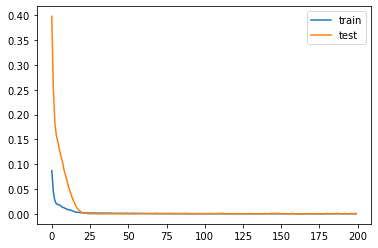

Train RMSE : 0.045
Train R2 : 0.997
Test RMSE : 0.092
Test R2 : 0.994


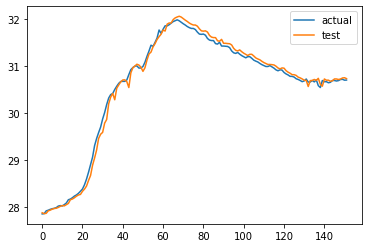

DSBH02_A 스케일러가 저장되었습니다.

DSBH02_A 모델이 저장되었습니다.

======= DSBH03_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.191314,0.0,0.206510
2,0.206510,0.0,0.208790
3,0.208790,0.0,0.205808
4,0.205808,0.0,0.200475
5,0.200475,0.0,0.190246


train_X : (420, 1, 2) 
train_y : (420,) 
test_X : (106, 1, 2) 
test_y : (106,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
28/28 - 1s - loss: 0.0347 - acc: 0.0024 - mae: 0.1572 - val_loss: 0.3279 - val_acc: 0.0000e+00 - val_mae: 0.4785
Epoch 2/200
28/28 - 0s - loss: 0.0142 - acc: 0.0024 - mae: 0.0934 - val_loss: 0.2298 - val_acc: 0.0000e+00 - val_m

Epoch 60/200
28/28 - 0s - loss: 6.6646e-04 - acc: 0.0024 - mae: 0.0185 - val_loss: 0.0047 - val_acc: 0.0094 - val_mae: 0.0533
Epoch 61/200
28/28 - 0s - loss: 5.2013e-04 - acc: 0.0024 - mae: 0.0169 - val_loss: 0.0051 - val_acc: 0.0094 - val_mae: 0.0556
Epoch 62/200
28/28 - 0s - loss: 5.5219e-04 - acc: 0.0024 - mae: 0.0172 - val_loss: 0.0035 - val_acc: 0.0094 - val_mae: 0.0462
Epoch 63/200
28/28 - 0s - loss: 5.6464e-04 - acc: 0.0024 - mae: 0.0171 - val_loss: 0.0031 - val_acc: 0.0094 - val_mae: 0.0436
Epoch 64/200
28/28 - 0s - loss: 5.7669e-04 - acc: 0.0024 - mae: 0.0179 - val_loss: 0.0033 - val_acc: 0.0094 - val_mae: 0.0449
Epoch 65/200
28/28 - 0s - loss: 6.5348e-04 - acc: 0.0024 - mae: 0.0186 - val_loss: 0.0027 - val_acc: 0.0094 - val_mae: 0.0410
Epoch 66/200
28/28 - 0s - loss: 5.5582e-04 - acc: 0.0024 - mae: 0.0172 - val_loss: 0.0027 - val_acc: 0.0094 - val_mae: 0.0412
Epoch 67/200
28/28 - 0s - loss: 5.3276e-04 - acc: 0.0024 - mae: 0.0170 - val_loss: 0.0031 - val_acc: 0.0094 - val_mae:

Epoch 125/200
28/28 - 0s - loss: 2.7081e-04 - acc: 0.0024 - mae: 0.0122 - val_loss: 0.0039 - val_acc: 0.0094 - val_mae: 0.0485
Epoch 126/200
28/28 - 0s - loss: 3.7435e-04 - acc: 0.0024 - mae: 0.0137 - val_loss: 0.0045 - val_acc: 0.0094 - val_mae: 0.0520
Epoch 127/200
28/28 - 0s - loss: 3.9019e-04 - acc: 0.0024 - mae: 0.0143 - val_loss: 0.0037 - val_acc: 0.0094 - val_mae: 0.0479
Epoch 128/200
28/28 - 0s - loss: 3.5134e-04 - acc: 0.0024 - mae: 0.0140 - val_loss: 0.0038 - val_acc: 0.0094 - val_mae: 0.0483
Epoch 129/200
28/28 - 0s - loss: 3.9223e-04 - acc: 0.0024 - mae: 0.0140 - val_loss: 0.0033 - val_acc: 0.0094 - val_mae: 0.0452
Epoch 130/200
28/28 - 0s - loss: 3.5582e-04 - acc: 0.0024 - mae: 0.0135 - val_loss: 0.0035 - val_acc: 0.0094 - val_mae: 0.0464
Epoch 131/200
28/28 - 0s - loss: 3.3487e-04 - acc: 0.0024 - mae: 0.0136 - val_loss: 0.0031 - val_acc: 0.0094 - val_mae: 0.0438
Epoch 132/200
28/28 - 0s - loss: 3.2925e-04 - acc: 0.0024 - mae: 0.0134 - val_loss: 0.0032 - val_acc: 0.0094 - 

Epoch 190/200
28/28 - 0s - loss: 2.6175e-04 - acc: 0.0024 - mae: 0.0125 - val_loss: 0.0018 - val_acc: 0.0094 - val_mae: 0.0336
Epoch 191/200
28/28 - 0s - loss: 2.5961e-04 - acc: 0.0024 - mae: 0.0121 - val_loss: 0.0011 - val_acc: 0.0094 - val_mae: 0.0256
Epoch 192/200
28/28 - 0s - loss: 2.6802e-04 - acc: 0.0024 - mae: 0.0124 - val_loss: 0.0017 - val_acc: 0.0094 - val_mae: 0.0326
Epoch 193/200
28/28 - 0s - loss: 2.7901e-04 - acc: 0.0024 - mae: 0.0123 - val_loss: 8.1572e-04 - val_acc: 0.0094 - val_mae: 0.0228
Epoch 194/200
28/28 - 0s - loss: 2.7487e-04 - acc: 0.0024 - mae: 0.0120 - val_loss: 8.2205e-04 - val_acc: 0.0094 - val_mae: 0.0227
Epoch 195/200
28/28 - 0s - loss: 3.3104e-04 - acc: 0.0024 - mae: 0.0138 - val_loss: 8.7513e-04 - val_acc: 0.0094 - val_mae: 0.0231
Epoch 196/200
28/28 - 0s - loss: 3.0966e-04 - acc: 0.0024 - mae: 0.0131 - val_loss: 7.9039e-04 - val_acc: 0.0094 - val_mae: 0.0218
Epoch 197/200
28/28 - 0s - loss: 3.2077e-04 - acc: 0.0024 - mae: 0.0132 - val_loss: 4.8906e-04 

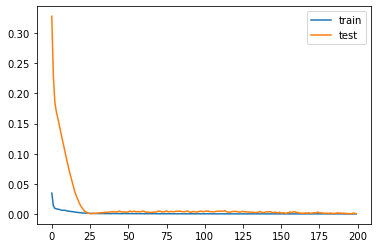

Train RMSE : 0.041
Train R2 : 0.992
Test RMSE : 0.118
Test R2 : 0.995


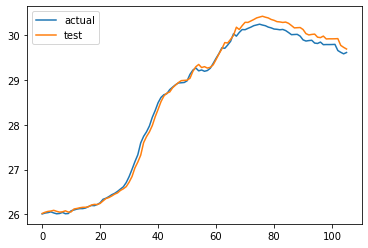

DSBH03_A 스케일러가 저장되었습니다.

DSBH03_A 모델이 저장되었습니다.

======= DSBH04_A =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.673608,0.0,0.673121
2,0.673121,0.0,0.659084
3,0.659084,0.0,0.566081
4,0.566081,0.0,0.574073
5,0.574073,0.0,0.502516


train_X : (597, 1, 2) 
train_y : (597,) 
test_X : (150, 1, 2) 
test_y : (150,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
40/40 - 2s - loss: 0.1371 - acc: 0.0017 - mae: 0.3422 - val_loss: 0.3302 - val_acc: 0.0000e+00 - val_mae: 0.5392
Epoch 2/200
40/40 - 0s - loss: 0.0485 - acc: 0.0017 - mae: 0.1959 - val_loss: 0.1324 - val_acc: 0.0000e+00 - val_m

Epoch 58/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0320 - val_loss: 2.4485e-04 - val_acc: 0.0000e+00 - val_mae: 0.0123
Epoch 59/200
40/40 - 0s - loss: 0.0020 - acc: 0.0017 - mae: 0.0345 - val_loss: 3.1229e-04 - val_acc: 0.0000e+00 - val_mae: 0.0150
Epoch 60/200
40/40 - 0s - loss: 0.0018 - acc: 0.0017 - mae: 0.0328 - val_loss: 3.0669e-04 - val_acc: 0.0000e+00 - val_mae: 0.0147
Epoch 61/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0319 - val_loss: 2.9065e-04 - val_acc: 0.0000e+00 - val_mae: 0.0137
Epoch 62/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0323 - val_loss: 2.5752e-04 - val_acc: 0.0000e+00 - val_mae: 0.0129
Epoch 63/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0314 - val_loss: 2.9231e-04 - val_acc: 0.0000e+00 - val_mae: 0.0143
Epoch 64/200
40/40 - 0s - loss: 0.0017 - acc: 0.0017 - mae: 0.0319 - val_loss: 2.8560e-04 - val_acc: 0.0000e+00 - val_mae: 0.0141
Epoch 65/200
40/40 - 0s - loss: 0.0019 - acc: 0.0017 - mae: 0.0325 - val_loss: 3.4563e-04 

Epoch 121/200
40/40 - 0s - loss: 7.3928e-04 - acc: 0.0017 - mae: 0.0187 - val_loss: 2.3736e-04 - val_acc: 0.0000e+00 - val_mae: 0.0127
Epoch 122/200
40/40 - 0s - loss: 8.2672e-04 - acc: 0.0017 - mae: 0.0202 - val_loss: 2.9882e-04 - val_acc: 0.0000e+00 - val_mae: 0.0151
Epoch 123/200
40/40 - 0s - loss: 7.8083e-04 - acc: 0.0017 - mae: 0.0195 - val_loss: 2.4857e-04 - val_acc: 0.0000e+00 - val_mae: 0.0136
Epoch 124/200
40/40 - 0s - loss: 7.2891e-04 - acc: 0.0017 - mae: 0.0181 - val_loss: 1.7408e-04 - val_acc: 0.0000e+00 - val_mae: 0.0102
Epoch 125/200
40/40 - 0s - loss: 7.1641e-04 - acc: 0.0017 - mae: 0.0189 - val_loss: 2.9061e-04 - val_acc: 0.0000e+00 - val_mae: 0.0149
Epoch 126/200
40/40 - 0s - loss: 6.8023e-04 - acc: 0.0017 - mae: 0.0181 - val_loss: 3.9604e-04 - val_acc: 0.0000e+00 - val_mae: 0.0170
Epoch 127/200
40/40 - 0s - loss: 7.2704e-04 - acc: 0.0017 - mae: 0.0185 - val_loss: 2.1311e-04 - val_acc: 0.0000e+00 - val_mae: 0.0103
Epoch 128/200
40/40 - 0s - loss: 7.3398e-04 - acc: 0.00

Epoch 182/200
40/40 - 0s - loss: 6.3112e-04 - acc: 0.0017 - mae: 0.0166 - val_loss: 3.2124e-04 - val_acc: 0.0000e+00 - val_mae: 0.0163
Epoch 183/200
40/40 - 0s - loss: 7.0696e-04 - acc: 0.0017 - mae: 0.0170 - val_loss: 3.0644e-04 - val_acc: 0.0000e+00 - val_mae: 0.0154
Epoch 184/200
40/40 - 0s - loss: 6.5668e-04 - acc: 0.0017 - mae: 0.0168 - val_loss: 9.0782e-04 - val_acc: 0.0000e+00 - val_mae: 0.0279
Epoch 185/200
40/40 - 0s - loss: 6.7364e-04 - acc: 0.0017 - mae: 0.0174 - val_loss: 4.4150e-04 - val_acc: 0.0000e+00 - val_mae: 0.0193
Epoch 186/200
40/40 - 0s - loss: 6.7516e-04 - acc: 0.0017 - mae: 0.0169 - val_loss: 3.2257e-04 - val_acc: 0.0000e+00 - val_mae: 0.0153
Epoch 187/200
40/40 - 0s - loss: 6.3513e-04 - acc: 0.0017 - mae: 0.0168 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mae: 0.0311
Epoch 188/200
40/40 - 0s - loss: 6.3954e-04 - acc: 0.0017 - mae: 0.0172 - val_loss: 4.3364e-04 - val_acc: 0.0000e+00 - val_mae: 0.0189
Epoch 189/200
40/40 - 0s - loss: 6.2639e-04 - acc: 0.0017 -

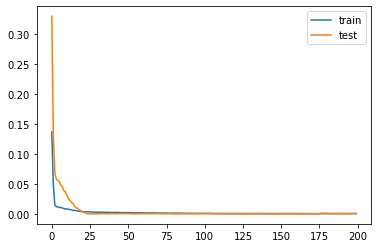

Train RMSE : 0.116
Train R2 : 0.985
Test RMSE : 0.071
Test R2 : 0.998


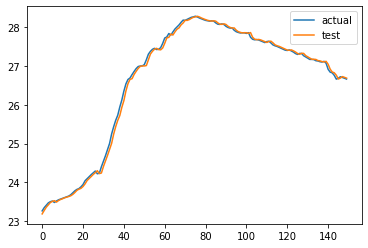

DSBH04_A 스케일러가 저장되었습니다.

DSBH04_A 모델이 저장되었습니다.

======= DSBH01_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.377178,0.0,0.372360
2,0.372360,0.0,0.363054
3,0.363054,0.0,0.361742
4,0.361742,0.0,0.359672
5,0.359672,0.0,0.358316


train_X : (469, 1, 2) 
train_y : (469,) 
test_X : (118, 1, 2) 
test_y : (118,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
32/32 - 2s - loss: 0.1489 - acc: 0.0021 - mae: 0.3570 - val_loss: 0.4786 - val_acc: 0.0000e+00 - val_mae: 0.6885
Epoch 2/200
32/32 - 0s - loss: 0.0650 - acc: 0.0021 - mae: 0.2305 - val_loss: 0.2536 - val_acc: 0.0000e+00 - val_m

Epoch 60/200
32/32 - 0s - loss: 0.0022 - acc: 0.0021 - mae: 0.0367 - val_loss: 3.9255e-04 - val_acc: 0.0085 - val_mae: 0.0164
Epoch 61/200
32/32 - 0s - loss: 0.0022 - acc: 0.0021 - mae: 0.0373 - val_loss: 8.2501e-04 - val_acc: 0.0085 - val_mae: 0.0253
Epoch 62/200
32/32 - 0s - loss: 0.0021 - acc: 0.0021 - mae: 0.0342 - val_loss: 2.8021e-04 - val_acc: 0.0085 - val_mae: 0.0134
Epoch 63/200
32/32 - 0s - loss: 0.0025 - acc: 0.0021 - mae: 0.0387 - val_loss: 5.1255e-04 - val_acc: 0.0085 - val_mae: 0.0191
Epoch 64/200
32/32 - 0s - loss: 0.0020 - acc: 0.0021 - mae: 0.0361 - val_loss: 9.1055e-04 - val_acc: 0.0085 - val_mae: 0.0270
Epoch 65/200
32/32 - 0s - loss: 0.0024 - acc: 0.0021 - mae: 0.0383 - val_loss: 3.9981e-04 - val_acc: 0.0085 - val_mae: 0.0168
Epoch 66/200
32/32 - 0s - loss: 0.0025 - acc: 0.0021 - mae: 0.0383 - val_loss: 1.5669e-04 - val_acc: 0.0085 - val_mae: 0.0095
Epoch 67/200
32/32 - 0s - loss: 0.0023 - acc: 0.0021 - mae: 0.0376 - val_loss: 8.4483e-04 - val_acc: 0.0085 - val_mae:

Epoch 125/200
32/32 - 0s - loss: 8.5497e-04 - acc: 0.0021 - mae: 0.0215 - val_loss: 4.4013e-04 - val_acc: 0.0085 - val_mae: 0.0180
Epoch 126/200
32/32 - 0s - loss: 9.3800e-04 - acc: 0.0021 - mae: 0.0225 - val_loss: 4.3267e-04 - val_acc: 0.0085 - val_mae: 0.0177
Epoch 127/200
32/32 - 0s - loss: 0.0012 - acc: 0.0021 - mae: 0.0250 - val_loss: 3.8492e-04 - val_acc: 0.0085 - val_mae: 0.0165
Epoch 128/200
32/32 - 0s - loss: 0.0010 - acc: 0.0021 - mae: 0.0230 - val_loss: 4.6368e-04 - val_acc: 0.0085 - val_mae: 0.0183
Epoch 129/200
32/32 - 0s - loss: 0.0011 - acc: 0.0021 - mae: 0.0230 - val_loss: 3.5519e-04 - val_acc: 0.0085 - val_mae: 0.0159
Epoch 130/200
32/32 - 0s - loss: 8.9530e-04 - acc: 0.0021 - mae: 0.0222 - val_loss: 6.9053e-04 - val_acc: 0.0085 - val_mae: 0.0234
Epoch 131/200
32/32 - 0s - loss: 8.8885e-04 - acc: 0.0021 - mae: 0.0222 - val_loss: 5.9790e-04 - val_acc: 0.0085 - val_mae: 0.0215
Epoch 132/200
32/32 - 0s - loss: 8.1653e-04 - acc: 0.0021 - mae: 0.0212 - val_loss: 4.3530e-04 

Epoch 188/200
32/32 - 0s - loss: 6.6083e-04 - acc: 0.0021 - mae: 0.0173 - val_loss: 1.2265e-04 - val_acc: 0.0085 - val_mae: 0.0083
Epoch 189/200
32/32 - 0s - loss: 7.1868e-04 - acc: 0.0021 - mae: 0.0177 - val_loss: 1.9002e-04 - val_acc: 0.0085 - val_mae: 0.0111
Epoch 190/200
32/32 - 0s - loss: 7.2886e-04 - acc: 0.0021 - mae: 0.0182 - val_loss: 2.6923e-04 - val_acc: 0.0085 - val_mae: 0.0136
Epoch 191/200
32/32 - 0s - loss: 7.4975e-04 - acc: 0.0021 - mae: 0.0186 - val_loss: 1.3957e-04 - val_acc: 0.0085 - val_mae: 0.0088
Epoch 192/200
32/32 - 0s - loss: 6.4867e-04 - acc: 0.0021 - mae: 0.0169 - val_loss: 9.5943e-05 - val_acc: 0.0085 - val_mae: 0.0066
Epoch 193/200
32/32 - 0s - loss: 6.9719e-04 - acc: 0.0021 - mae: 0.0176 - val_loss: 1.0687e-04 - val_acc: 0.0085 - val_mae: 0.0078
Epoch 194/200
32/32 - 0s - loss: 7.2297e-04 - acc: 0.0021 - mae: 0.0176 - val_loss: 1.1714e-04 - val_acc: 0.0085 - val_mae: 0.0084
Epoch 195/200
32/32 - 0s - loss: 7.3304e-04 - acc: 0.0021 - mae: 0.0174 - val_loss:

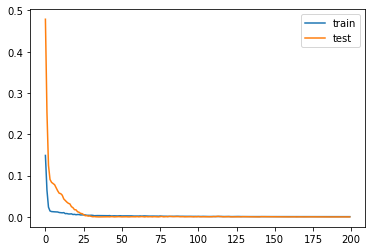

Train RMSE : 0.115
Train R2 : 0.989
Test RMSE : 0.084
Test R2 : 0.977


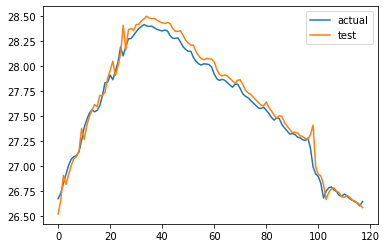

DSBH01_B 스케일러가 저장되었습니다.

DSBH01_B 모델이 저장되었습니다.

======= DSBH02_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.556774,0.0,0.554873
2,0.554873,0.0,0.557053
3,0.557053,0.0,0.574840
4,0.574840,0.0,0.572497
5,0.572497,0.0,0.571761


train_X : (605, 1, 2) 
train_y : (605,) 
test_X : (152, 1, 2) 
test_y : (152,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
41/41 - 2s - loss: 0.0772 - acc: 0.0017 - mae: 0.2062 - val_loss: 0.3964 - val_acc: 0.0000e+00 - val_mae: 0.5860
Epoch 2/200
41/41 - 0s - loss: 0.0420 - acc: 0.0017 - mae: 0.1407 - val_loss: 0.2648 - val_acc: 0.0000e+00 - val_m

Epoch 60/200
41/41 - 0s - loss: 9.9030e-04 - acc: 0.0017 - mae: 0.0211 - val_loss: 5.7106e-04 - val_acc: 0.0066 - val_mae: 0.0195
Epoch 61/200
41/41 - 0s - loss: 0.0011 - acc: 0.0017 - mae: 0.0212 - val_loss: 5.8514e-04 - val_acc: 0.0066 - val_mae: 0.0193
Epoch 62/200
41/41 - 0s - loss: 9.9972e-04 - acc: 0.0017 - mae: 0.0212 - val_loss: 6.3013e-04 - val_acc: 0.0066 - val_mae: 0.0200
Epoch 63/200
41/41 - 0s - loss: 9.7148e-04 - acc: 0.0017 - mae: 0.0212 - val_loss: 0.0010 - val_acc: 0.0066 - val_mae: 0.0268
Epoch 64/200
41/41 - 0s - loss: 0.0012 - acc: 0.0017 - mae: 0.0216 - val_loss: 6.4567e-04 - val_acc: 0.0066 - val_mae: 0.0209
Epoch 65/200
41/41 - 0s - loss: 0.0010 - acc: 0.0017 - mae: 0.0209 - val_loss: 6.2653e-04 - val_acc: 0.0066 - val_mae: 0.0208
Epoch 66/200
41/41 - 0s - loss: 0.0011 - acc: 0.0017 - mae: 0.0216 - val_loss: 5.2718e-04 - val_acc: 0.0066 - val_mae: 0.0185
Epoch 67/200
41/41 - 0s - loss: 9.3099e-04 - acc: 0.0017 - mae: 0.0206 - val_loss: 3.7770e-04 - val_acc: 0.006

Epoch 124/200
41/41 - 0s - loss: 6.0933e-04 - acc: 0.0017 - mae: 0.0167 - val_loss: 4.1781e-04 - val_acc: 0.0066 - val_mae: 0.0141
Epoch 125/200
41/41 - 0s - loss: 5.2142e-04 - acc: 0.0017 - mae: 0.0159 - val_loss: 6.6038e-04 - val_acc: 0.0066 - val_mae: 0.0215
Epoch 126/200
41/41 - 0s - loss: 6.1097e-04 - acc: 0.0017 - mae: 0.0169 - val_loss: 4.8461e-04 - val_acc: 0.0066 - val_mae: 0.0181
Epoch 127/200
41/41 - 0s - loss: 6.6943e-04 - acc: 0.0017 - mae: 0.0170 - val_loss: 6.6900e-04 - val_acc: 0.0066 - val_mae: 0.0219
Epoch 128/200
41/41 - 0s - loss: 6.7449e-04 - acc: 0.0017 - mae: 0.0172 - val_loss: 4.9586e-04 - val_acc: 0.0066 - val_mae: 0.0177
Epoch 129/200
41/41 - 0s - loss: 5.6198e-04 - acc: 0.0017 - mae: 0.0166 - val_loss: 4.6559e-04 - val_acc: 0.0066 - val_mae: 0.0153
Epoch 130/200
41/41 - 0s - loss: 6.5898e-04 - acc: 0.0017 - mae: 0.0170 - val_loss: 4.3852e-04 - val_acc: 0.0066 - val_mae: 0.0143
Epoch 131/200
41/41 - 0s - loss: 7.2988e-04 - acc: 0.0017 - mae: 0.0188 - val_loss:

Epoch 187/200
41/41 - 0s - loss: 6.3310e-04 - acc: 0.0017 - mae: 0.0182 - val_loss: 0.0018 - val_acc: 0.0066 - val_mae: 0.0384
Epoch 188/200
41/41 - 0s - loss: 7.4128e-04 - acc: 0.0017 - mae: 0.0200 - val_loss: 4.6591e-04 - val_acc: 0.0066 - val_mae: 0.0180
Epoch 189/200
41/41 - 0s - loss: 4.6548e-04 - acc: 0.0017 - mae: 0.0153 - val_loss: 5.6595e-04 - val_acc: 0.0066 - val_mae: 0.0193
Epoch 190/200
41/41 - 0s - loss: 5.6963e-04 - acc: 0.0017 - mae: 0.0163 - val_loss: 4.2063e-04 - val_acc: 0.0066 - val_mae: 0.0172
Epoch 191/200
41/41 - 0s - loss: 6.6433e-04 - acc: 0.0017 - mae: 0.0177 - val_loss: 4.5615e-04 - val_acc: 0.0066 - val_mae: 0.0165
Epoch 192/200
41/41 - 0s - loss: 5.7695e-04 - acc: 0.0017 - mae: 0.0171 - val_loss: 5.4652e-04 - val_acc: 0.0066 - val_mae: 0.0192
Epoch 193/200
41/41 - 0s - loss: 5.3868e-04 - acc: 0.0017 - mae: 0.0158 - val_loss: 4.2169e-04 - val_acc: 0.0066 - val_mae: 0.0166
Epoch 194/200
41/41 - 0s - loss: 5.6338e-04 - acc: 0.0017 - mae: 0.0179 - val_loss: 0.0

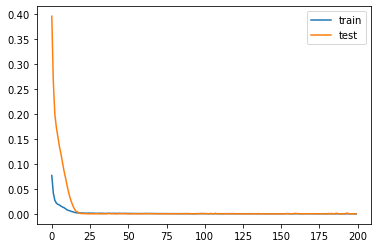

Train RMSE : 0.037
Train R2 : 0.998
Test RMSE : 0.080
Test R2 : 0.996


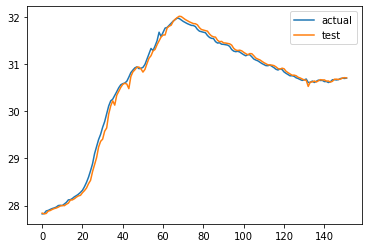

DSBH02_B 스케일러가 저장되었습니다.

DSBH02_B 모델이 저장되었습니다.

======= DSBH03_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.118980,0.0,0.136161
2,0.136161,0.0,0.132659
3,0.132659,0.0,0.127059
4,0.127059,0.0,0.120853
5,0.120853,0.0,0.113898


train_X : (447, 1, 2) 
train_y : (447,) 
test_X : (112, 1, 2) 
test_y : (112,)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
30/30 - 2s - loss: 0.0516 - acc: 0.0022 - mae: 0.1897 - val_loss: 0.5145 - val_acc: 0.0000e+00 - val_mae: 0.7123
Epoch 2/200
30/30 - 0s - loss: 0.0221 - acc: 0.0022 - mae: 0.1197 - val_loss: 0.3366 - val_acc: 0.0000e+00 - val_m

Epoch 61/200
30/30 - 0s - loss: 9.3564e-04 - acc: 0.0022 - mae: 0.0219 - val_loss: 0.0025 - val_acc: 0.0089 - val_mae: 0.0462
Epoch 62/200
30/30 - 0s - loss: 8.7891e-04 - acc: 0.0022 - mae: 0.0211 - val_loss: 0.0021 - val_acc: 0.0089 - val_mae: 0.0419
Epoch 63/200
30/30 - 0s - loss: 8.2037e-04 - acc: 0.0022 - mae: 0.0207 - val_loss: 0.0020 - val_acc: 0.0089 - val_mae: 0.0413
Epoch 64/200
30/30 - 0s - loss: 8.5337e-04 - acc: 0.0022 - mae: 0.0211 - val_loss: 0.0026 - val_acc: 0.0089 - val_mae: 0.0469
Epoch 65/200
30/30 - 0s - loss: 9.8352e-04 - acc: 0.0022 - mae: 0.0222 - val_loss: 0.0031 - val_acc: 0.0089 - val_mae: 0.0519
Epoch 66/200
30/30 - 0s - loss: 8.0902e-04 - acc: 0.0022 - mae: 0.0205 - val_loss: 0.0027 - val_acc: 0.0089 - val_mae: 0.0482
Epoch 67/200
30/30 - 0s - loss: 0.0010 - acc: 0.0022 - mae: 0.0225 - val_loss: 0.0031 - val_acc: 0.0089 - val_mae: 0.0517
Epoch 68/200
30/30 - 0s - loss: 8.6303e-04 - acc: 0.0022 - mae: 0.0211 - val_loss: 0.0021 - val_acc: 0.0089 - val_mae: 0.0

Epoch 126/200
30/30 - 0s - loss: 5.4466e-04 - acc: 0.0022 - mae: 0.0171 - val_loss: 0.0019 - val_acc: 0.0089 - val_mae: 0.0398
Epoch 127/200
30/30 - 0s - loss: 6.0325e-04 - acc: 0.0022 - mae: 0.0185 - val_loss: 0.0021 - val_acc: 0.0089 - val_mae: 0.0422
Epoch 128/200
30/30 - 0s - loss: 6.0596e-04 - acc: 0.0022 - mae: 0.0179 - val_loss: 0.0014 - val_acc: 0.0089 - val_mae: 0.0338
Epoch 129/200
30/30 - 0s - loss: 5.7893e-04 - acc: 0.0022 - mae: 0.0172 - val_loss: 0.0019 - val_acc: 0.0089 - val_mae: 0.0401
Epoch 130/200
30/30 - 0s - loss: 5.2693e-04 - acc: 0.0022 - mae: 0.0167 - val_loss: 0.0015 - val_acc: 0.0089 - val_mae: 0.0348
Epoch 131/200
30/30 - 0s - loss: 5.2372e-04 - acc: 0.0022 - mae: 0.0168 - val_loss: 0.0017 - val_acc: 0.0089 - val_mae: 0.0382
Epoch 132/200
30/30 - 0s - loss: 5.2444e-04 - acc: 0.0022 - mae: 0.0170 - val_loss: 0.0022 - val_acc: 0.0089 - val_mae: 0.0438
Epoch 133/200
30/30 - 0s - loss: 5.2512e-04 - acc: 0.0022 - mae: 0.0167 - val_loss: 0.0019 - val_acc: 0.0089 - 

Epoch 190/200
30/30 - 0s - loss: 5.4416e-04 - acc: 0.0022 - mae: 0.0173 - val_loss: 6.8276e-04 - val_acc: 0.0089 - val_mae: 0.0235
Epoch 191/200
30/30 - 0s - loss: 4.6467e-04 - acc: 0.0022 - mae: 0.0163 - val_loss: 5.4165e-04 - val_acc: 0.0089 - val_mae: 0.0208
Epoch 192/200
30/30 - 0s - loss: 4.8058e-04 - acc: 0.0022 - mae: 0.0163 - val_loss: 1.9833e-04 - val_acc: 0.0089 - val_mae: 0.0115
Epoch 193/200
30/30 - 0s - loss: 5.0644e-04 - acc: 0.0022 - mae: 0.0168 - val_loss: 1.8011e-04 - val_acc: 0.0089 - val_mae: 0.0093
Epoch 194/200
30/30 - 0s - loss: 5.1003e-04 - acc: 0.0022 - mae: 0.0163 - val_loss: 1.4788e-04 - val_acc: 0.0089 - val_mae: 0.0081
Epoch 195/200
30/30 - 0s - loss: 4.6229e-04 - acc: 0.0022 - mae: 0.0157 - val_loss: 2.9429e-04 - val_acc: 0.0089 - val_mae: 0.0143
Epoch 196/200
30/30 - 0s - loss: 4.3212e-04 - acc: 0.0022 - mae: 0.0156 - val_loss: 1.7356e-04 - val_acc: 0.0089 - val_mae: 0.0090
Epoch 197/200
30/30 - 0s - loss: 4.9979e-04 - acc: 0.0022 - mae: 0.0166 - val_loss:

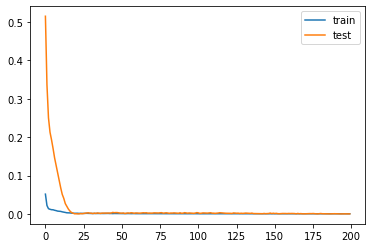

Train RMSE : 0.056
Train R2 : 0.992
Test RMSE : 0.077
Test R2 : 0.969


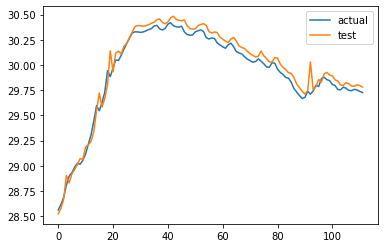

DSBH03_B 스케일러가 저장되었습니다.

DSBH03_B 모델이 저장되었습니다.

======= DSBH04_B =======
1번 째 시도


,var1(t-1),var2(t-1),var1(t)
1,0.915973,0.0,0.915462
2,0.915462,0.0,0.921360
3,0.921360,0.0,0.953678
4,0.953678,0.0,0.941560
5,0.941560,0.0,0.938246


train_X : (500, 1, 2) 
train_y : (500,) 
test_X : (125, 1, 2) 
test_y : (125,)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________
loss:오차  - acc:  - mae:  - val_loss:  - val_acc:  - val_mae: 
Epoch 1/200
34/34 - 1s - loss: 0.1902 - acc: 0.0020 - mae: 0.3423 - val_loss: 0.0219 - val_acc: 0.0000e+00 - val_mae: 0.1303
Epoch 2/200
34/34 - 0s - loss: 0.1157 - acc: 0.0020 - mae: 0.2489 - val_loss: 0.0054 - val_acc: 0.0000e+00 - val_m

Epoch 58/200
34/34 - 0s - loss: 0.0037 - acc: 0.0040 - mae: 0.0414 - val_loss: 1.8572e-04 - val_acc: 0.0000e+00 - val_mae: 0.0111
Epoch 59/200
34/34 - 0s - loss: 0.0040 - acc: 0.0040 - mae: 0.0436 - val_loss: 1.8367e-04 - val_acc: 0.0000e+00 - val_mae: 0.0111
Epoch 60/200
34/34 - 0s - loss: 0.0041 - acc: 0.0040 - mae: 0.0427 - val_loss: 2.1872e-04 - val_acc: 0.0000e+00 - val_mae: 0.0117
Epoch 61/200
34/34 - 0s - loss: 0.0038 - acc: 0.0040 - mae: 0.0408 - val_loss: 1.7288e-04 - val_acc: 0.0000e+00 - val_mae: 0.0107
Epoch 62/200
34/34 - 0s - loss: 0.0027 - acc: 0.0040 - mae: 0.0368 - val_loss: 1.6983e-04 - val_acc: 0.0000e+00 - val_mae: 0.0106
Epoch 63/200
34/34 - 0s - loss: 0.0036 - acc: 0.0040 - mae: 0.0414 - val_loss: 1.6237e-04 - val_acc: 0.0000e+00 - val_mae: 0.0104
Epoch 64/200
34/34 - 0s - loss: 0.0030 - acc: 0.0040 - mae: 0.0386 - val_loss: 1.7134e-04 - val_acc: 0.0000e+00 - val_mae: 0.0105
Epoch 65/200
34/34 - 0s - loss: 0.0031 - acc: 0.0040 - mae: 0.0387 - val_loss: 1.4343e-04 

Epoch 121/200
34/34 - 0s - loss: 0.0018 - acc: 0.0040 - mae: 0.0288 - val_loss: 1.6428e-04 - val_acc: 0.0000e+00 - val_mae: 0.0104
Epoch 122/200
34/34 - 0s - loss: 0.0016 - acc: 0.0040 - mae: 0.0284 - val_loss: 1.6566e-04 - val_acc: 0.0000e+00 - val_mae: 0.0104
Epoch 123/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0302 - val_loss: 1.2355e-04 - val_acc: 0.0000e+00 - val_mae: 0.0090
Epoch 124/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0310 - val_loss: 2.8104e-04 - val_acc: 0.0000e+00 - val_mae: 0.0136
Epoch 125/200
34/34 - 0s - loss: 0.0022 - acc: 0.0040 - mae: 0.0319 - val_loss: 2.3920e-04 - val_acc: 0.0000e+00 - val_mae: 0.0124
Epoch 126/200
34/34 - 0s - loss: 0.0023 - acc: 0.0040 - mae: 0.0322 - val_loss: 1.3373e-04 - val_acc: 0.0000e+00 - val_mae: 0.0095
Epoch 127/200
34/34 - 0s - loss: 0.0019 - acc: 0.0040 - mae: 0.0300 - val_loss: 1.4521e-04 - val_acc: 0.0000e+00 - val_mae: 0.0098
Epoch 128/200
34/34 - 0s - loss: 0.0018 - acc: 0.0040 - mae: 0.0298 - val_loss: 1.5

Epoch 184/200
34/34 - 0s - loss: 0.0013 - acc: 0.0040 - mae: 0.0249 - val_loss: 1.2547e-04 - val_acc: 0.0000e+00 - val_mae: 0.0091
Epoch 185/200
34/34 - 0s - loss: 0.0015 - acc: 0.0040 - mae: 0.0274 - val_loss: 1.7353e-04 - val_acc: 0.0000e+00 - val_mae: 0.0107
Epoch 186/200
34/34 - 0s - loss: 0.0015 - acc: 0.0040 - mae: 0.0282 - val_loss: 2.3164e-04 - val_acc: 0.0000e+00 - val_mae: 0.0125
Epoch 187/200
34/34 - 0s - loss: 0.0018 - acc: 0.0040 - mae: 0.0303 - val_loss: 9.9453e-05 - val_acc: 0.0000e+00 - val_mae: 0.0079
Epoch 188/200
34/34 - 0s - loss: 0.0014 - acc: 0.0040 - mae: 0.0265 - val_loss: 1.3182e-04 - val_acc: 0.0000e+00 - val_mae: 0.0093
Epoch 189/200
34/34 - 0s - loss: 0.0013 - acc: 0.0040 - mae: 0.0250 - val_loss: 1.0882e-04 - val_acc: 0.0000e+00 - val_mae: 0.0083
Epoch 190/200
34/34 - 0s - loss: 0.0016 - acc: 0.0040 - mae: 0.0264 - val_loss: 1.1133e-04 - val_acc: 0.0000e+00 - val_mae: 0.0084
Epoch 191/200
34/34 - 0s - loss: 0.0014 - acc: 0.0040 - mae: 0.0263 - val_loss: 1.3

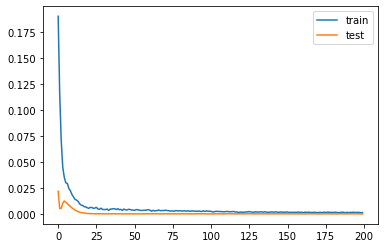

Train RMSE : 0.039
Train R2 : 0.998
Test RMSE : 0.030
Test R2 : 0.986


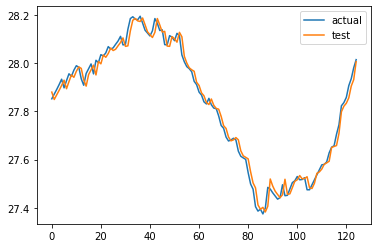

DSBH04_B 스케일러가 저장되었습니다.

DSBH04_B 모델이 저장되었습니다.



In [ ]:
start(0)

CSV File has been created


23922it [02:00, 198.86it/s]
998it [00:02, 351.24it/s]


,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B,rain
_date,,,,,,,,,
2018-11-13,NaN,29.374598,NaN,26.035976,NaN,29.762949,NaN,29.857251,0.0
2018-11-14,NaN,29.450510,NaN,26.032637,NaN,29.753466,NaN,29.855676,0.0
2018-11-15,NaN,29.542585,NaN,25.936289,NaN,29.764339,NaN,29.873859,0.0
2018-11-16,NaN,29.654344,NaN,25.297936,NaN,29.853032,NaN,29.973508,0.0
2018-11-17,NaN,29.599985,NaN,25.352791,NaN,29.841348,NaN,29.936141,0.0
...,...,...,...,...,...,...,...,...,...
2021-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2021-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2021-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


DSBH01_A
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


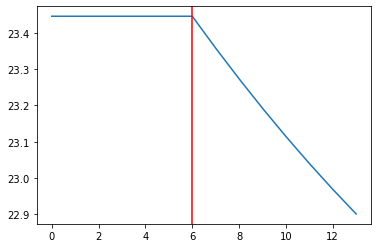

DSBH02_A
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


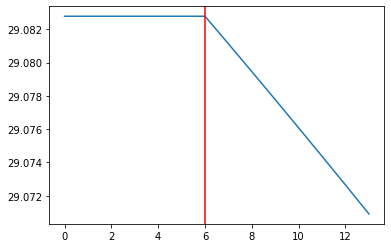

DSBH03_A
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


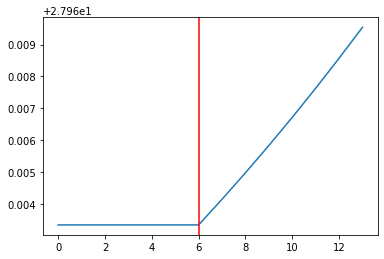

DSBH04_A
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


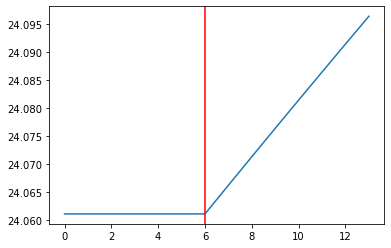

DSBH01_B
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


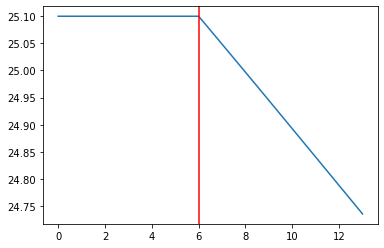

DSBH02_B
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


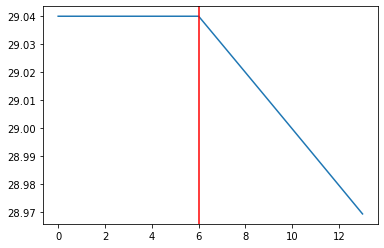

DSBH03_B
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


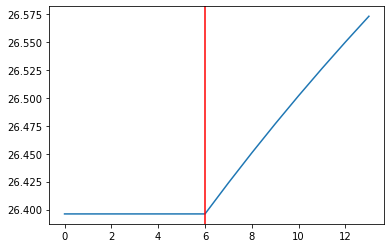

DSBH04_B
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 60)                15120     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 61        
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


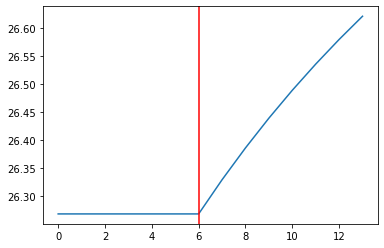

,DSBH01_A,DSBH02_A,DSBH03_A,DSBH04_A,DSBH01_B,DSBH02_B,DSBH03_B,DSBH04_B
2021-08-07,23.357771,29.081121,27.964140,24.066225,25.048161,29.029947,26.423918,26.328936
2021-08-08,23.273355,29.079454,27.964972,24.071314,24.996571,29.019876,26.450802,26.385942
2021-08-09,23.192305,29.077772,27.965830,24.076372,24.944738,29.009785,26.476816,26.439224
2021-08-10,23.114618,29.076077,27.966715,24.081406,24.892721,28.999680,26.502008,26.489145
2021-08-11,23.040268,29.074369,27.967630,24.086411,24.840580,28.989557,26.526424,26.536020
2021-08-12,22.969212,29.072649,27.968573,24.091391,24.788380,28.979425,26.550108,26.580128
2021-08-13,22.901403,29.070913,27.969545,24.096344,24.736181,28.969276,26.573101,26.621710


In [ ]:
start(1)